In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import os

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
torch.cuda.set_device(7)
import time

import torchvision
from torchvision import transforms as T

import tqdm


import warnings
warnings.filterwarnings('ignore')
torch.cuda.is_available()
device = 'cuda'
root_dir = "/home/user/michigan/data/AGM01"

## Define model structure

In [2]:
latent_dims = 64
capacity = 32
variational_beta = 1

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 56 x 56
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: 2c x 28 x 28
        self.fc_mu = nn.Linear(in_features=c*2*28*28, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*28*28, out_features=latent_dims)
            
    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.sigmoid(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*28*28)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 28, 28) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.sigmoid(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 112*112), x.view(-1, 112*112), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    


In [4]:
# device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder().to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 9752835


In [5]:
for i in os.listdir():
    if i == "model%s.pt" % latent_dims:
        vae.load_state_dict(torch.load(i))
        vae.to(device)

## Define Dataloader

In [6]:
class AGMDS(D.Dataset):
    def __init__(self, df, week, transform=None, channels=[0,1,2]):
        self.week = week
        self.df = df
        self.root_path = "/home/user/michigan/data/AGM01/"
        self.channels = channels
        self.img_dir = self.root_path+self.week
        self.len = df.shape[0]
        self.transforms = transform
        
    @staticmethod
    def _load_img_as_tensor(self, file_name):
        with Image.open(file_name) as img:
            img = img.resize((112,112),resample=Image.NEAREST)
            pixels = np.asarray(img)
            pixels = pixels.astype('float32')
            # Scale them to 0~1
            maxmum = pixels.max()
            pixels = pixels / maxmum
            return T.ToTensor()(pixels)

    def _get_img_path(self, index, channel):
        well, field, cell_idx = self.df.iloc[index]["Metadata_WellID_Nuclei"], self.df.iloc[index]["Metadata_FieldID_Nuclei"], self.df.iloc[index]["ObjectNumber_Nuclei"]
        return "/home/user/michigan/data/AGM01/Single_%s/%s_%s_%s_%s.tif" % (self.week, well, field, ("Ch" + str(channel)), cell_idx)
    
    def __getitem__(self, index):
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        img = torch.cat([self._load_img_as_tensor(self, img_path) for img_path in paths])
        return img, self.df.iloc[index]["Metadata_WellID_Nuclei"] 

    def __len__(self):
        return self.len
    

In [8]:
week_list=["Week1_22123","Week1_22141"]
Week1_df = pd.read_csv(root_dir+"/features/"+week_list[1]+"_Joined.csv")

In [9]:
batch_size = 64
AGMData = AGMDS(df = Week1_df, week = week_list[1])

loader = D.DataLoader(AGMData, batch_size=batch_size, shuffle=True)
# optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

## Reconstruction

In [10]:
images, well = iter(loader).next()

In [11]:
def show_image(img):
#     img = to_img(img)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Original images


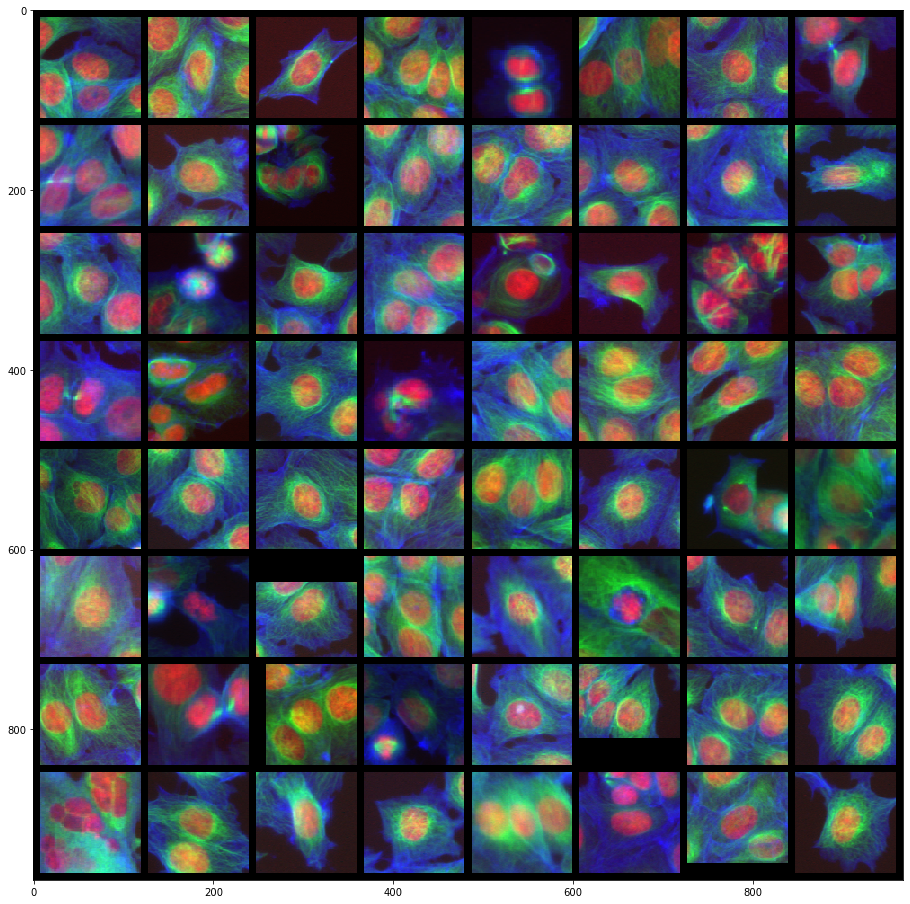

In [12]:
print('Original images')
plt.figure(figsize=(16, 16))
show_image(torchvision.utils.make_grid(images,8,8))
plt.show()

VAE reconstruction:


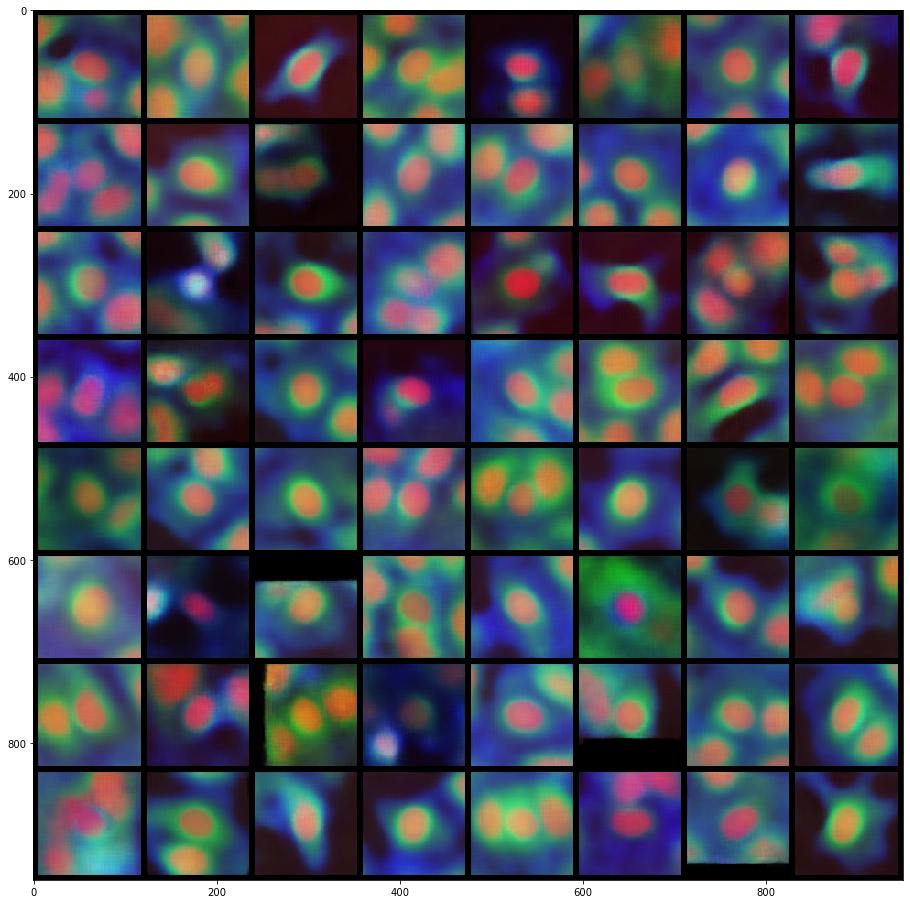

In [13]:
print('VAE reconstruction:')
with torch.no_grad():
    plt.figure(figsize=(16, 16))
    images = images.to(device)
    recon_images, _, _ = vae(images)
    recon_images = recon_images.cpu()
#     recon_images = to_img(recon_images)
    np_imagegrid = torchvision.utils.make_grid(recon_images, 8, 6).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

## Generate code from images

In [14]:
def generate_code(week_list):
    for i in range(len(week_list)):
        Week1_df = pd.read_csv(root_dir+"/features/"+week_list[i]+"_Joined.csv")
        batch_size = 64
        AGMData = AGMDS(df = Week1_df, week = week_list[i])
        loader = D.DataLoader(AGMData, batch_size=batch_size, shuffle=True)
        code_well = pd.DataFrame()
        for j, (image_batch, label) in enumerate(loader):
            code = vae(image_batch.to(device))[1].cpu().detach().numpy()
            well = np.asarray(label)

            code_well = code_well.append(pd.DataFrame(np.column_stack((code, well))))

            if j%200 == 0:
                code_well.to_csv("./latent/%scode_data%d.csv" % (week_list[i], code_well.shape[0]))
                print(week_list[i])
                print(code_well.shape)
        code_well.to_csv("./latent/%scode_data%d.csv" % (week_list[i], code_well.shape[0]))

In [16]:
generate_code(["Week1_22123"])

Week1_22123
(64, 65)
Week1_22123
(12864, 65)
Week1_22123
(25664, 65)


In [38]:
["Week1_22381","Week1_22401","Week6_31641","Week6_31661",
              "Week6_31681","Week7_34341","Week7_34381","Week7_34641","Week9_39282",
              "Week9_39283","Week9_39301"]

Single_Week1_22123  Single_Week1_22381	Single_Week6_31681  Single_Week9_39282
Single_Week1_22141  Single_Week1_22401	Single_Week7_34341  Single_Week9_39283
Single_Week1_22161  Single_Week6_31641	Single_Week7_34381  Single_Week9_39301
Single_Week1_22361  Single_Week6_31661	Single_Week7_34641  features


## MOA classification

In [20]:
moa = pd.read_csv("/home/user/michigan/data/BBBC021/BBBC021_v1_moa.csv")

In [26]:
moa[moa["compound"]=="AZ138"]

,compound,concentration,moa
19,AZ138,0.30,Eg5 inhibitors
23,AZ138,3.00,Eg5 inhibitors
71,AZ138,0.10,Eg5 inhibitors
74,AZ138,1.00,Eg5 inhibitors
90,AZ138,0.03,Eg5 inhibitors


In [46]:
whole_table = pd.DataFrame()
for i in os.listdir("./latent"):
    if i.split(".")[-1] == "csv":
        table = pd.read_csv(i)
        

Week1_22123code_data26985.csv
Week1_22141code_data455.csv
Week1_22161code_data27424.csv
Week1_22361code_data624.csv
Week1_22381code_data657.csv
Week1_22401code_data666.csv
Week6_31641code_data468.csv
Week6_31661code_data560.csv
Week6_31681code_data398.csv
Week7_34341code_data524.csv
Week7_34381code_data432.csv
Week7_34641code_data741.csv
Week9_39282code_data227.csv
Week9_39283code_data358.csv
Week9_39301code_data219.csv


In [49]:
whole_table = pd.DataFrame()

In [45]:
'Week6_31681code_data398.csv'.split(".")[-1]

'csv'